# Introduction to GeoPandas and Geospatial Vector Data

In this second practical session we will begin more hands-on work with geospatial *vector* data (i.e. points, lines, and polygons). We will also introduce the `GeoPandas` package and explore some of its key features for working with this type of data.

Objectives:
* Read/write spatial vector datasets in different formats
* Create/convert/view geometry data
* Produce basic plots of spatial data


In [ ]:
# load packages
import geopandas as gpd

## Overview and helpful links

Remember that GeoPandas is a developing project that makes dealing with geospatial data in Python much easier. It leverages components from several other projects, including `pandas`, `shapely`, and `fiona`. 

To learn more and to find the documentation to these projects following these links:
* GeoPandas
    * [https://geopandas.org/](https://geopandas.org/)
    * [https://geopandas.readthedocs.io/en/latest/](https://geopandas.readthedocs.io/en/latest/)
* pandas - for DataFrames
    * [https://pandas.pydata.org/](https://pandas.pydata.org/)
* shapely - for geometry
    * [https://shapely.readthedocs.io/en/latest/](https://shapely.readthedocs.io/en/latest/)
* fiona - for file I/O
    * [https://fiona.readthedocs.io/en/latest/](https://fiona.readthedocs.io/en/latest/)

Under the hood, these packages rely on other libraries like GDAL/OGR ([https://www.osgeo.org/projects/gdal/](https://www.osgeo.org/projects/gdal/)) and proj ([https://www.osgeo.org/projects/proj/](https://www.osgeo.org/projects/proj/)).

Refer back to the documentation as you explore the practicals during this workshop. There are many helpful features and we won't be able to cover everything.


### Background on working with tabular data

The practicals will try to give enough guidance and examples of working with different data types, but if you have less experience with `pandas` you may want to refer back to some of the other tutorials for additional help.

* [https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html](https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html)

## Geospatial vector data

There are different mathematical data models that can be used to represent objects, surfaces, or other geographic phenomena. These specify how data are defined, organised, updated, and queried. The *vector* data model is one example (and as we discussed in the lecture, it is usually contrasted with the *raster* data model).

Vector data represent features whose geometry can consist of:
* Points - a vertex or position in space with X, Y, and optionally Z coordinates

* Lines - sets of vertices linked by paths where the start and ending point are not the same location

* Polygons - a closed shape formed by a set of vertices and paths in a set order, where the start and ending point are the same

Don't confuse the data model with a specific file format. There are now several different file formats that can be used to store geospatial vector data (see also: [https://en.wikipedia.org/wiki/GIS_file_formats](https://en.wikipedia.org/wiki/GIS_file_formats)).

The *shapefile* is still a well-known and common file format because it is used by a major GIS software company ESRI). Other common formats you're likely to encounter are: *geopackages* and *GeoJSON* files. You might notice that the files we're using in the `\data` directory are compressed (&ast;.zip). This is mostly for convenience of storing them on Github. Working with your own data you may want to leave them unzipped.

Try unzipping one of the shapefiles (&ast;.shp.zip). You will see that it isn't one file, but a collection of several files. These contain the geometry, the attributes, coordinate information. And you have to keep them all together.

If you unzip one of the geopackages (&ast;.gpkg.zip) and inspect it, you will see that inside is actually a SQLite database (which adhere to certain standards: [https://www.geopackage.org/](https://www.geopackage.org/)). There are manay ways to work with vector data files, and we're going to focus just on using `GeoPandas` and Python.

Regardless of the format of the vector data, `fiona` makes it easy to read into GeoPandas using the `geopandas.read_file` command.


In [ ]:
# load an example of vector data
# we will use a set of US states 
gdf = gpd.read_file()

# if we have an uncompressed shapefile instead, point towards the *.shp file: gpd.read_file('\path\to\data.shp')

## Linking place and attributes

The key idea and the real power of geospatial data comes from linking information about a feature to a location in space or in the real-world. This may seem obvious and straight-forward, but it (as we will see) opens up many possibilities for how to integrate many different kinds of data and what questions we can starts to ask and answer.

In GeoPandas this central idea of linking attributes to places is operationalised with the core data structure of the `GeoDataFrame`.

The data we just loaded is an example of a `GeoDataFrame`.

In [ ]:
type(gdf)

In [ ]:
gdf.head()

We saw some of these operations in the first practical, but let's look at the results in a bit more detail this time.

* `.head()` shows the first rows of the dataset (from Pandas)
* each row is an observation or a feature to be represented
* the **attributes** of the observations in the `GeoDataFrame` are columns of data (in a `DataFrame`)
* there is the additional **'geometry'** column
* in this example, the geometry is using polygons


Because the `gdf` is still (also) a **DataFrame** from pandas, we can work with the attribute columns as normal.

We can select a subset of attributes and even convert the `GeoDataFrame` back into a pandas `DataFrame` by removing the geometry attribute if we really want to.

We can subset rows of the dataframe into a new DataFrame based on conditions.

The geometry column deserves a bit more attention.

In [ ]:
# extract just the geometry attribute
gs = gdf.geometry

In [ ]:
type(gs)

In [ ]:
gs.head()

This column is a unique attribute for spatial dataframes. In GeoPandas it is a `GeoSeries` and it is a set of shapes for each observation in the DataFrame. It is also made up of `shapely` objects. Because of this, the `GeoSeries` allows us to use most of the methods and attributes from `shapely`.

In [ ]:
# access the shape areas
gs.area[0:4]

We can also access and work with invidual elements of the geometry series, though in practice we may not often do this.

In [ ]:
# get the first record and plot its geometry
gdf.loc[0, 'geometry'].plot()

In [ ]:
# or as an alternative
gdf.geometry[0].plot()

## Creating a GeoDataFrame

If we don't have a ready-made GIS file, there are several ways we can construct a GeoDataFrame within Python.

### Constructing manually

It's possible to construct the GeoDataFrame with the attribute data.

In [28]:
# first need to import geometry objects
from shapely.geometry import Point, LineString, Polygon

In [22]:
# create a test dataset manually
test = gpd.GeoDataFrame({
                         'geometry': [Point(1, 1), Point(2,2)],
                         'var1': [1, 2],
                         'var2': [3, 4]
                        })

print(test)
type(test)

                  geometry  var1  var2
0  POINT (1.00000 1.00000)     1     3
1  POINT (2.00000 2.00000)     2     4


geopandas.geodataframe.GeoDataFrame

Notice that I called the column **'geometry'**, but that can be changed.

In [23]:
test = test.rename(columns={'geometry': 'shape'}).set_geometry('shape')

test

,shape,var1,var2
0,POINT (1.00000 1.00000),1,3
1,POINT (2.00000 2.00000),2,4


In [24]:
test.geometry

0    POINT (1.00000 1.00000)
1    POINT (2.00000 2.00000)
Name: shape, dtype: geometry

The `.geometry` attribute will always return the active column, or we can check its actual name.

In [25]:
test.geometry.name

'shape'

But it's still a `GeoDataFrame`.

In [26]:
type(test)

geopandas.geodataframe.GeoDataFrame

**Side Track**

The example above shows how it can be quite easy to construct geometries. Let's try a few others.

POLYGON ((0.5 1, 1 2, 0.75 3, 0.75 3.5, 0.5 4, 0.5 1))


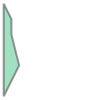

In [32]:
# Test poplygon
poly = Polygon([(0.5, 1), (1, 2), (.75, 3), (.75, 3.5), (.5, 4)])

# notice that it `Polygon` automatically closes our set of vertices!
print(poly)
poly

LINESTRING (0.5 1, 1 2, 0.75 3, 0.75 3.5, 0.5 4)


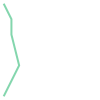

In [33]:
# Test line (or "linestring")
# using the same set of coordates as above
ln = LineString([(0.5, 1), (1, 2), (.75, 3), (.75, 3.5), (.5, 4)])

# this time the points aren't closed
print(ln)
ln

#### Try for yourself!

Experiment with making a few of your own geometries for points, lines, and polygons. 

What happens when:
* a `LineString` ends at the same point it started with?
* a `Polygon` intersects itself (repeating a vertex)?

Can you store different geometry types within the same GeoDataFrame?
* Hint: construct something like `test` above, but don't use all `Point` elements.

In [ ]:
# Test your code here...

### Constructing from a `pandas` DataFrame

More commonly than manually creating data, we will need to create a GeoDataFrame from an existing DataFrame which might also contain geometry information. In the example below we are going to read in a `.csv` file which contains some coordinate locations and then we'll create a GeoDataFrame.

## Saving or exporting data

Once we've finished creating or manipulating a GeoDataFrame in our notebooks, we may want to save that as a new output file.

## Bonus section: Big Data

For most analyses (and certainly everything we will do in this workshop) you can use the `geopandas.read_file` command to use standard `fiona` processes to read/write your files. But what about when you have some really, *really* big datasets?

Below I'm going to show you a few tips and tricks and resources that might come in handy for your research.

For starters, we won't 

### Reading in batches of records

### Writing to a SQL database

Future options: Apache, dask, parquet tiles